## NLP: Natural Language Processing
### Analise de sentimentos

<img src="https://miro.medium.com/max/960/0*xLRsbQ02J7sQpNNy" width=400 height=400/>

### Imports

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
import kerastuner as kt
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding
from tensorflow.keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
#from kerastuner.tuners import BayesianOptimization
#nltk.download('stopwords')

Using TensorFlow backend.
<ipython-input-1-eae617846774>:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


### Métodos

In [2]:
TAG_RE = re.compile(r'<[^>]+>')
list_stop_words = set(stopwords.words('english'))
    
# plot resultados
def plot_results(history):
    # acuracia
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()


# pre-processamento
def preprocess_text(sen):
    
    # Removing html tags
    sentence = TAG_RE.sub('', sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # lowercase
    sentence = sentence.lower()
    
    # remove stopwords
    #sentence = [w for w in sentence if w not in list_stop_words]

    return sentence

### Dataset

In [3]:
movie_reviews = pd.read_csv("data/IMDB Dataset.csv")
print (movie_reviews.isnull().values.any())
print (movie_reviews.shape)

# amostra
movie_reviews, _ = train_test_split(movie_reviews, train_size=0.5, random_state=42, stratify=movie_reviews['sentiment'])
print (movie_reviews.shape)
movie_reviews.head()

False
(50000, 2)
(25000, 2)


,review,sentiment
3055,Trio's vignettes were insightful and quite enj...,positive
47326,I had never heard of this one before the owner...,negative
48869,This is an excellent but hard to find trippy W...,positive
48623,"I am a huge fan of big, loud, trashy, complete...",positive
39657,"Easily Lucio Fulci's most respected film, ""Don...",positive


### Analises

negative    12500
positive    12500
Name: sentiment, dtype: int64


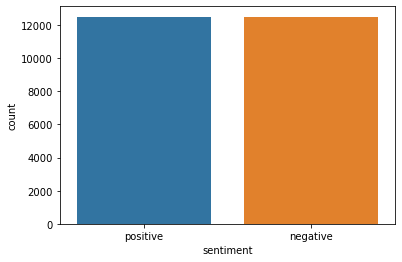

In [4]:
print (movie_reviews['sentiment'].value_counts(dropna=False))
sns.countplot(x='sentiment', data=movie_reviews)

### Pre-processamento

In [5]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

### Separa dados em treino e teste

In [6]:
# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val_tmp, X_test_tmp, y_val_tmp, y_test_tmp = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

### Tokenizer

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val_tmp = tokenizer.texts_to_sequences(X_val_tmp)
X_test_tmp = tokenizer.texts_to_sequences(X_test_tmp)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val_tmp = pad_sequences(X_val_tmp, padding='post', maxlen=maxlen)
X_test_tmp = pad_sequences(X_test_tmp, padding='post', maxlen=maxlen)

## Modelos com Bag of Words

### Bag of Words

<img src="https://i.ibb.co/j5Dj80T/bad.png" width=400 height=400/>

In [8]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### BoW (Bag of Words) + Logistic Regression

In [9]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

# score medio
y_pred = classifier.predict_proba(df_train_str)[:, 1]

Train Accuracy: 0.9461
Test Accuracy: 0.8364


### Score test

In [10]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)   
        instance = ' '.join([str(x) for x in instance])
        
        #transform test
        instance = CountVec.transform([instance])

        #create dataframe
        instance=pd.DataFrame(instance.toarray(), columns=CountVec.get_feature_names())

        score = classifier.predict_proba(instance)[:, 1][0]
        print (score)
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']
# score list
score_list(list_instances)

0.9602899778227699
0.26013185613117773


,text,score,rating
0,"The movie was amazing, I loved it, very good",0.960290,Positivo
1,"I hate this movie, it is very bad and terrible",0.260132,Negativo


### BoW (Bag of Words) + Naive Bayes

In [11]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8206
Test Accuracy: 0.7626


### BoW (Bag of Words) + Random Forest

In [12]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.804
Test Accuracy: 0.7914


## Modelos com tf-idf

<img src="https://miro.medium.com/max/1000/1*KZrjbKHcsWt-zzUj2oRk3w.jpeg" width=400 height=400/>

<img src="https://i.ytimg.com/vi/vZAXpvHhQow/maxresdefault.jpg" width=600 height=60/>

In [13]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
vectorizer = TfidfVectorizer()

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### Tf-Idf (Bag of Words) + Logistic Regression

In [14]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.9461
Test Accuracy: 0.8364


### Tf-Idf (Bag of Words) + Naive Bayes

In [15]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8206
Test Accuracy: 0.7626


### Tf-Idf (Bag of Words) + Decision Tree

In [16]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.6582
Test Accuracy: 0.6548


### Tf-Idf (Bag of Words) + Random Forest (max_depth=3)

In [17]:
classifier = RandomForestClassifier(max_depth=3)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.7904
Test Accuracy: 0.7928


### Tf-Idf (Bag of Words) + Random Forest (max_depth=5)

In [18]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8057
Test Accuracy: 0.7862


### Tf-Idf (Bag of Words) + Random Forest (max_depth=7)

In [19]:
classifier = RandomForestClassifier(max_depth=7)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8201
Test Accuracy: 0.797


### Tf-Idf (Bag of Words) + Random Forest (max_depth=15)

In [20]:
classifier = RandomForestClassifier(max_depth=15)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8846
Test Accuracy: 0.81


## Modelos com Embedding

### Regressão Logística

In [21]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.5343
Test Accuracy: 0.5098


### Naive Bayes

In [22]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.5394
Test Accuracy: 0.5288


### Árvore de Decisão

In [23]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.5494
Test Accuracy: 0.5144


### Random Forest

In [24]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.6632
Test Accuracy: 0.5556


### Modelo simples com Redes Neurais v1 (sem Early Stopping)

Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 146.0728 - acc: 0.4942 - val_loss: 2.9678 - val_acc: 0.5010
Epoch 2/50
125/125 [==============================] - 0s 1ms/step - loss: 19.1464 - acc: 0.5017 - val_loss: 0.7705 - val_acc: 0.4958
Epoch 3/50
125/125 [==============================] - 0s 1ms/step - loss: 7.4362 - acc: 0.5018 - val_loss: 0.7283 - val_acc: 0.4963
Epoch 4/50
125/125 [==============================] - 0s 1ms/step - loss: 4.2157 - acc: 0.4971 - val_loss: 0.7145 - val_acc: 0.4963
Epoch 5/50
125/125 [==============================] - 0s 1ms/step - loss: 2.9159 - acc: 0.4994 - val_loss: 0.7036 - val_acc: 0.4963
Epoch 6/50
125/125 [==============================] - 0s 1ms/step - loss: 1.9525 - acc: 0.5002 - val_loss: 0.6937 - val_acc: 0.4963
Epoch 7/50
125/125 [==============================] - 0s 1ms/step - loss: 1.6945 - acc: 0.4978 - val_loss: 0.6932 - val_acc: 0.4952
Epoch 8/50
125/125 [==============================] - 0s 1ms/step - loss:

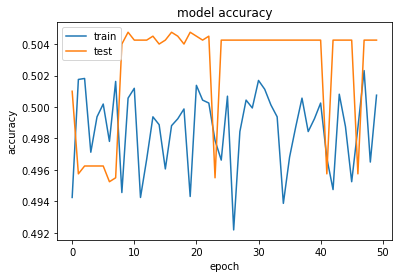

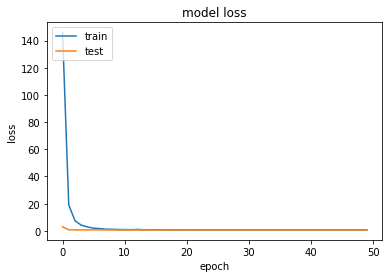

In [25]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Modelo simples com Redes Neurais  (Early Stopping)

Epoch 1/30
123/157 [======================>.......] - ETA: 0s - loss: 86.6829 - acc: 0.4999 
Epoch 00001: val_loss improved from inf to 27.34586, saving model to best_model.h5
157/157 [==============================] - 0s 2ms/step - loss: 74.3880 - acc: 0.5008 - val_loss: 27.3459 - val_acc: 0.4955
Epoch 2/30
148/157 [===========================>..] - ETA: 0s - loss: 17.4112 - acc: 0.5106
Epoch 00002: val_loss improved from 27.34586 to 10.38356, saving model to best_model.h5
157/157 [==============================] - 0s 1ms/step - loss: 17.0277 - acc: 0.5100 - val_loss: 10.3836 - val_acc: 0.5030
Epoch 3/30
110/157 [====================>.........] - ETA: 0s - loss: 7.2141 - acc: 0.5176
Epoch 00003: val_loss improved from 10.38356 to 4.81144, saving model to best_model.h5
157/157 [==============================] - 0s 1ms/step - loss: 6.4181 - acc: 0.5149 - val_loss: 4.8114 - val_acc: 0.5027
Epoch 4/30
121/157 [======================>.......] - ETA: 0s - loss: 2.9924 - acc: 0.5214
Epoch 00

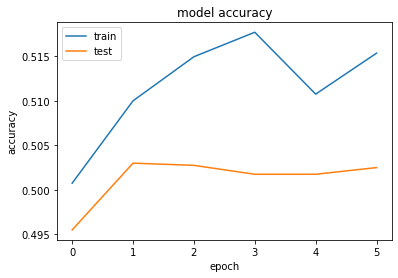

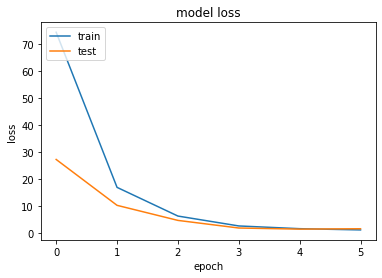

In [26]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_val_tmp, y_val_tmp), batch_size=128, epochs=30, verbose=1, callbacks=[es, mc])
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Simple Model Embedding layer (sem Glove)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          6855600   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 10001     
Total params: 6,865,601
Trainable params: 6,865,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.6285 - acc: 0.6683
Epoch 00001: val_loss improved from inf to 0.47921, saving model to best_model.h5
125/125 [==============================] - 14s 115ms/step - loss: 0.6285 - acc: 0.6683 - val_loss: 0.4792 - val_acc: 0.7922
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.

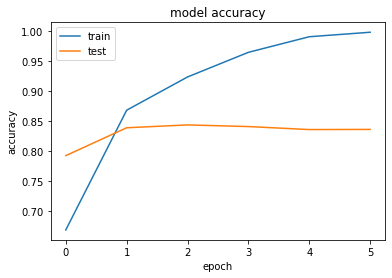

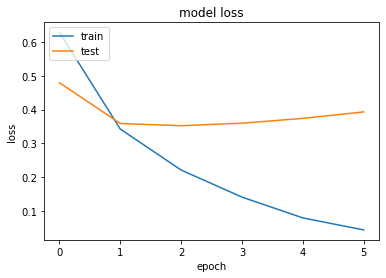

In [27]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Glove

In [28]:
embeddings_dictionary = dict()
glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Simple Model Glove (sem Early Stopping)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          6855600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 10001     
Total params: 6,865,601
Trainable params: 10,001
Non-trainable params: 6,855,600
_________________________________________________________________
None
Epoch 1/20
125/125 [==============================] - 1s 5ms/step - loss: 0.6376 - acc: 0.6385 - val_loss: 0.5902 - val_acc: 0.6802
Epoch 2/20
125/125 [==============================] - 0s 4ms/step - loss: 0.5031 - acc: 0.7625 - val_loss: 0.5688 - val_acc: 0.6990
Epoch 3/20
125/125 [==============================] - 0s 4ms/step - loss: 0.4610 - acc: 0.7854 - val

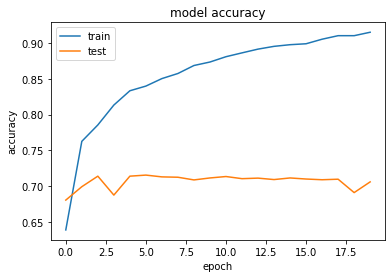

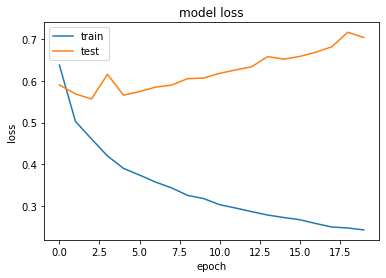

In [29]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Simple Model Glove (com Early Stopping)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          6855600   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 10001     
Total params: 6,865,601
Trainable params: 10,001
Non-trainable params: 6,855,600
_________________________________________________________________
None
Epoch 1/30
121/125 [============================>.] - ETA: 0s - loss: 0.6379 - acc: 0.6353
Epoch 00001: val_loss improved from inf to 0.58542, saving model to best_model.h5
125/125 [==============================] - 1s 6ms/step - loss: 0.6360 - acc: 0.6373 - val_loss: 0.5854 - val_acc: 0.6880
Epoch 2/30
120/125 [===========================>..] - ETA: 0s - loss: 

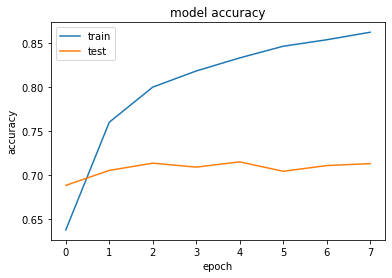

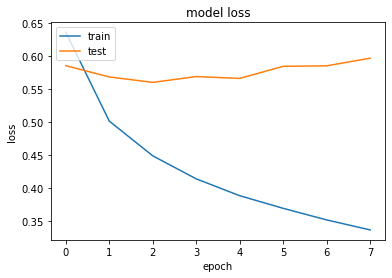

In [30]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### CNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          6855600   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 6,919,857
Trainable params: 64,257
Non-trainable params: 6,855,600
_________________________________________________________________
None
Epoch 1/50
125/125 [==============================] - 5s 42ms/step - loss: 0.5690 - acc: 0.6991 - val_loss: 0.4731 - val_acc: 0.7835
Epoch 2/50
125/125 [==============================] - 5s 42ms/step - loss: 0.4050 - acc: 0.8198 - v

157/157 [==============================] - 1s 4ms/step - loss: 0.6551 - acc: 0.8350
Train Accuracy: 0.9662500023841858
Test Accuracy: 0.8349999785423279


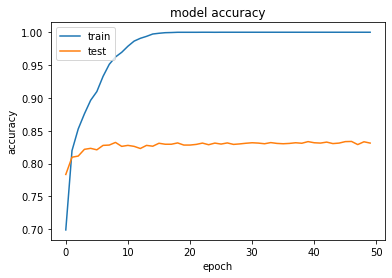

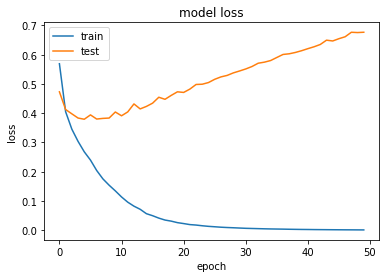

In [31]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### CNN Early Stopping

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.5688 - acc: 0.7078
Epoch 00001: val_loss improved from inf to 0.46783, saving model to best_model.h5
125/125 [==============================] - 6s 47ms/step - loss: 0.5688 - acc: 0.7078 - val_loss: 0.4678 - val_acc: 0.7828
Epoch 2/30
124/125 [============================>.] - ETA: 0s - loss: 0.4057 - acc: 0.8230
Epoch 00002: val_loss improved from 0.46783 to 0.41423, saving model to best_model.h5
125/125 [==============================] - 7s 53ms/step - loss: 0.4056 - acc: 0.8227 - val_loss: 0.4142 - val_acc: 0.8070
Epoch 3/30
124/125 [============================>.] - ETA: 0s - loss: 0.3484 - acc: 0.8503
Epoch 00003: val_loss improved from 0.41423 to 0.39625, saving model to best_model.h5
125/125 [==============================] - 6s 50ms/step - loss: 0.3485 - acc: 0.8502 - val_loss: 0.3963 - val_acc: 0.8195
Epoch 4/30
124/125 [============================>.] - ETA: 0s - loss: 0.2981 - acc: 0.8827- ETA: 1s - loss:

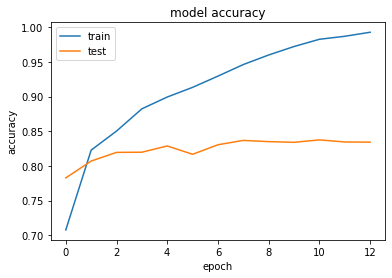

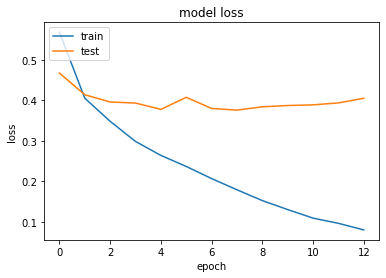

In [32]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### RNN

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          6855600   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               29312     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 6,885,041
Trainable params: 29,441
Non-trainable params: 6,855,600
_________________________________________________________________
None
Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.6934 - acc: 0.5464
Epoch 00001: val_loss improved from inf to 0.69523, saving model to best_model.h5
125/125 [==============================] - 9s 75ms/step - loss: 0.6934 - acc: 0.5464 - val_loss: 0.6952 - val_acc: 0.5500
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss:

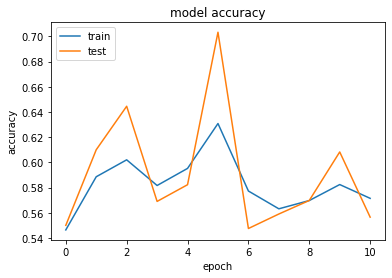

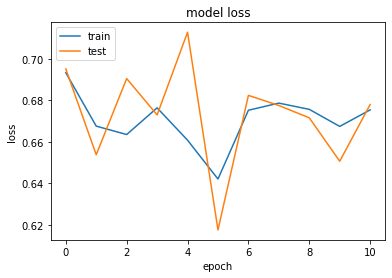

In [33]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### LSTM

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          6855600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 6,972,977
Trainable params: 117,377
Non-trainable params: 6,855,600
_________________________________________________________________
None
Epoch 1/15
125/125 [==============================] - 40s 321ms/step - loss: 0.6284 - acc: 0.6426 - val_loss: 0.5432 - val_acc: 0.7305
Epoch 2/15
125/125 [==============================] - 40s 323ms/step - loss: 0.5545 - acc: 0.7216 - val_loss: 0.4898 - val_acc: 0.7635
Epoch 3/15
125/125 [==============================] - 41s 329ms/step - loss: 0.5029 - acc: 0.

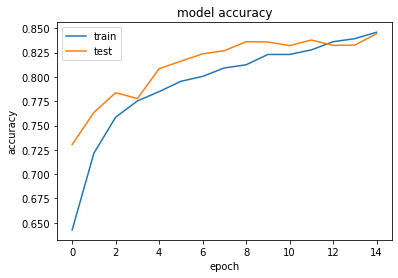

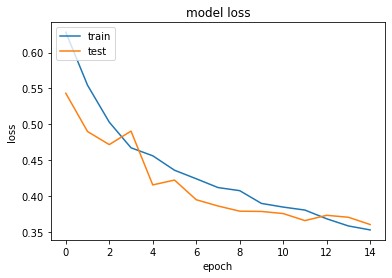

In [34]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### LSTM com Early Stopping

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          6855600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 6,972,977
Trainable params: 117,377
Non-trainable params: 6,855,600
_________________________________________________________________
None
Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.5983 - acc: 0.6719
Epoch 00001: val_loss improved from inf to 0.52120, saving model to best_model.h5
125/125 [==============================] - 39s 310ms/step - loss: 0.5983 - acc: 0.6719 - val_loss: 0.5212 - val_acc: 0.7505
Epoch 2/100
125/125 [==============================] - ETA: 0s - 

125/125 [==============================] - ETA: 0s - loss: 0.2921 - acc: 0.8721
Epoch 00027: val_loss did not improve from 0.34475
125/125 [==============================] - 38s 302ms/step - loss: 0.2921 - acc: 0.8721 - val_loss: 0.4465 - val_acc: 0.8320
Epoch 28/100
125/125 [==============================] - ETA: 0s - loss: 0.2991 - acc: 0.8668
Epoch 00028: val_loss did not improve from 0.34475
125/125 [==============================] - 36s 290ms/step - loss: 0.2991 - acc: 0.8668 - val_loss: 0.4048 - val_acc: 0.8430
Epoch 29/100
125/125 [==============================] - ETA: 0s - loss: 0.2835 - acc: 0.8774
Epoch 00029: val_loss did not improve from 0.34475
125/125 [==============================] - 37s 296ms/step - loss: 0.2835 - acc: 0.8774 - val_loss: 0.3870 - val_acc: 0.8415
Epoch 30/100
125/125 [==============================] - ETA: 0s - loss: 0.2764 - acc: 0.8792
Epoch 00030: val_loss did not improve from 0.34475
125/125 [==============================] - 36s 288ms/step - loss:

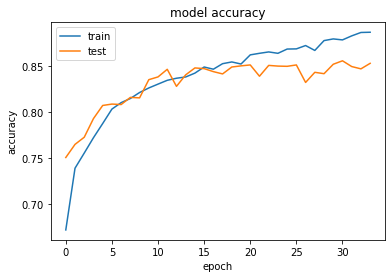

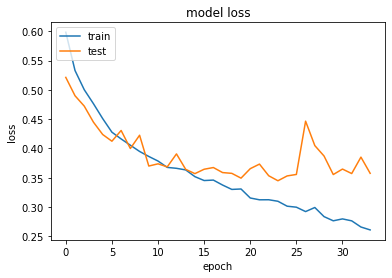

In [35]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, callbacks=[es, mc], validation_split=0.2)

# load a saved model (best model)
model = load_model('best_model.h5')
print(model.summary())

score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Prediction (sample)

In [36]:
instance = sample(X, 1)
print (instance)
instance = tokenizer.texts_to_sequences(instance)

instance = pad_sequences(instance, padding='post', maxlen=maxlen)
print (instance)

score = model.predict(instance)[0][0]
print (score)
if (score >= 0.5):
    print ('Positivo')
else:
    print ('Negativo')

['pretty pretty actresses and actors pretty bad script pretty frequent let strip to our undies scenes pretty fair x pretty jarring location decisions the college dorm room looks like high end hotel room probably because it was shot at hotel pretty bland storyline pretty awful dialog pretty locations pretty annoying editing unless you like the music video flash cut style this one isn a guilty pleasure this is more an embarrassing one if you must watch this pick good dance techno album and turn the sound off on the movie you ll see the pretty people in their pretty black undies and probably follow the story just fine the cast may be able to act doubt that anyone could look skilled given the lines plot that they had to deal with ']
[[  34  290  128 1512  643  236   84    6   10  314   27 1512  177 1983
   706  177  385  709  177 1815  177  597  822  860   17   34    1  205
   370 3128  580  404    8   25  210  127 2295 1587    8    5   48   30
  2169   25   41   17  199  100    8 1167   4

### Prediction (tests)

In [37]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)

        score = model.predict(instance)[0][0]
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']

# score list
score_list(list_instances)

,text,score,rating
0,"The movie was amazing, I loved it, very good",0.979307,Positivo
1,"I hate this movie, it is very bad and terrible",0.002117,Negativo
